# Shenzhen Dataset Exploration

This notebook is meant to explore the dataset and visualize descriptive statistics related to the metadata and chest X-Ray images contained in the dataset. The results and insights from these explorations will support understanding the data and help decide model features and parameters.

Without further ado, let's take a look at the data. :)

**Library Imports**

In [1]:
import os

import numpy as np
import pandas as pd
from keras.utils import load_img, img_to_array

# Plotting libraries
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from tqdm import tqdm

# Global variables
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
METADATA_PATH = os.path.join(DATA_DIR, 'raw', 'shenzhen_metadata.csv')

**Reading Data Files**

In [2]:
# Reading the metadata file
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df.reset_index(inplace=True)
print("Variables:")
print(metadata_df.columns)

print("\nNull entries check:")
print(metadata_df.isnull().sum())

Variables:
Index(['index', 'study_id', 'sex', 'age', 'findings'], dtype='object')

Null entries check:
index       0
study_id    0
sex         0
age         0
findings    0
dtype: int64


In [3]:
# For each variable in the dataset, check the entries
for col_ in metadata_df.columns[2:]:
    print("Variable:", col_)
    # Get unique entries for string variables
    if isinstance(metadata_df[col_][0], str):
        unique_entries, counts = np.unique(metadata_df[col_], return_counts=True)
        for entry_, count_ in zip(unique_entries, counts):
            print(entry_, ": ", count_)
    else:
        # Print summary statistics for numeric variables
        print(metadata_df[col_].describe())
    print("\n")


Variable: sex
Female :  202
Male :  460


Variable: age
count    662.000000
mean      35.575529
std       14.709271
min        1.000000
25%       26.000000
50%       33.000000
75%       43.000000
max       89.000000
Name: age, dtype: float64


Variable: findings
1.bilateral secondary PTB  with right upper atelectasis;2.right pleural adhesions;3.left compensatory emphysema :  1
1.secondary PTB  in the right upper field; 2.small tuberculoma; 3.right pleural thickening and adhesions :  1
Bilateral secondary PTB :  16
Bilateral secondary PTB  with most lesions calcified :  1
Bilateral secondary PTB , right pleural change after decortication :  1
Bilateral secondary PTB with left lower field pneumonia :  1
Bilateral secondary PTB, left encapsulated intrathoracic fluid :  1
Left PTB :  2
Left PTB, left pleural thickening :  1
Left secondary PTB in the upper and middle fields, mainly  fibrous  lesions :  1
Old PTB in the right upper field :  2
PTB :  2
PTB  in the right upper field :  3
PTB i

**Data Profile**

In [4]:
# Visualize patient profiles based on sex and age
male_ages = metadata_df["age"].loc[metadata_df["sex"]=="Male"]
female_ages = metadata_df["age"].loc[metadata_df["sex"]=="Female"]
fig = ff.create_distplot(
    [male_ages, female_ages], ["male", "female"],
    bin_size=3, show_curve=False, histnorm=None
)
fig.update_layout(title="Distribution of gender-based age groups")
fig.show()

In [5]:
print("Male, 10th & 90th ages percentile:")
print(male_ages.quantile([0.1, 0.9]))
print("Female, 10th & 90th ages percentile:")
print(female_ages.quantile([0.1, 0.9]))

Male, 10th & 90th ages percentile:
0.1    22.0
0.9    55.1
Name: age, dtype: float64
Female, 10th & 90th ages percentile:
0.1    22.0
0.9    59.0
Name: age, dtype: float64


Observations:
- Dataset contains more male chest X-Rays than females overall
- About 80% of both sex groups are between age 22 - 59 years old

**Checking Labels**  
Observations are marked as normal or bilateral/unilateral, primary/secondary TB, with some labels marking the location of the TB on the lung quadrants. For simplification, the labels are converted into binary labels indicating normal vs. TB-infected lungs.

In [6]:
# Creating the labels column in the metadata
metadata_df["labels"] = metadata_df["findings"].copy()

# Convert labels into "normal" or "tuberculosis"
for i, label_ in enumerate(metadata_df["labels"], start=0):
    label_ = label_.lower()

    if "ptb" in label_ or "tb" in label_ or "stb" in label_:
        metadata_df["labels"][i] = "tuberculosis"
    elif "normal" in label_:
        continue
    else:
        metadata_df["labels"][i] = None
print("Labels:", metadata_df["labels"].value_counts())
print("Dropped:", metadata_df["labels"].isnull().sum())

metadata_df = metadata_df.dropna()

# Save the processed metadata
metadata_df.to_csv(os.path.join(DATA_DIR, 'processed', 'shenzhen_metadata_labelled.csv'))

Labels: labels
tuberculosis    335
normal          326
Name: count, dtype: int64
Dropped: 1


**Raw Image Samples**

In [7]:
# Get image arrays of sample images per label
n_samples = 3
labels_list = metadata_df["labels"].value_counts().keys().to_list()

img_samples = {label_: list() for label_ in labels_list}
for label_ in img_samples.keys():
    img_samples_ = metadata_df.loc[metadata_df["labels"] == label_]["study_id"].sample(n_samples)
    img_samples[label_] = img_samples_

# Get all image arrays
print("Fetching image data...")
img_arrs = {name_: None for name_ in metadata_df["study_id"]}
for name_ in tqdm(img_arrs.keys()):
    image = load_img(
        os.path.join(DATA_DIR, 'raw', 'images', name_),
        target_size=(224, 224), color_mode="grayscale"
    )
    image_arr = img_to_array(image, data_format="channels_last", dtype=None)
    img_arrs[name_] = image_arr

Fetching image data...
100%|██████████| 661/661 [00:57<00:00, 11.44it/s]


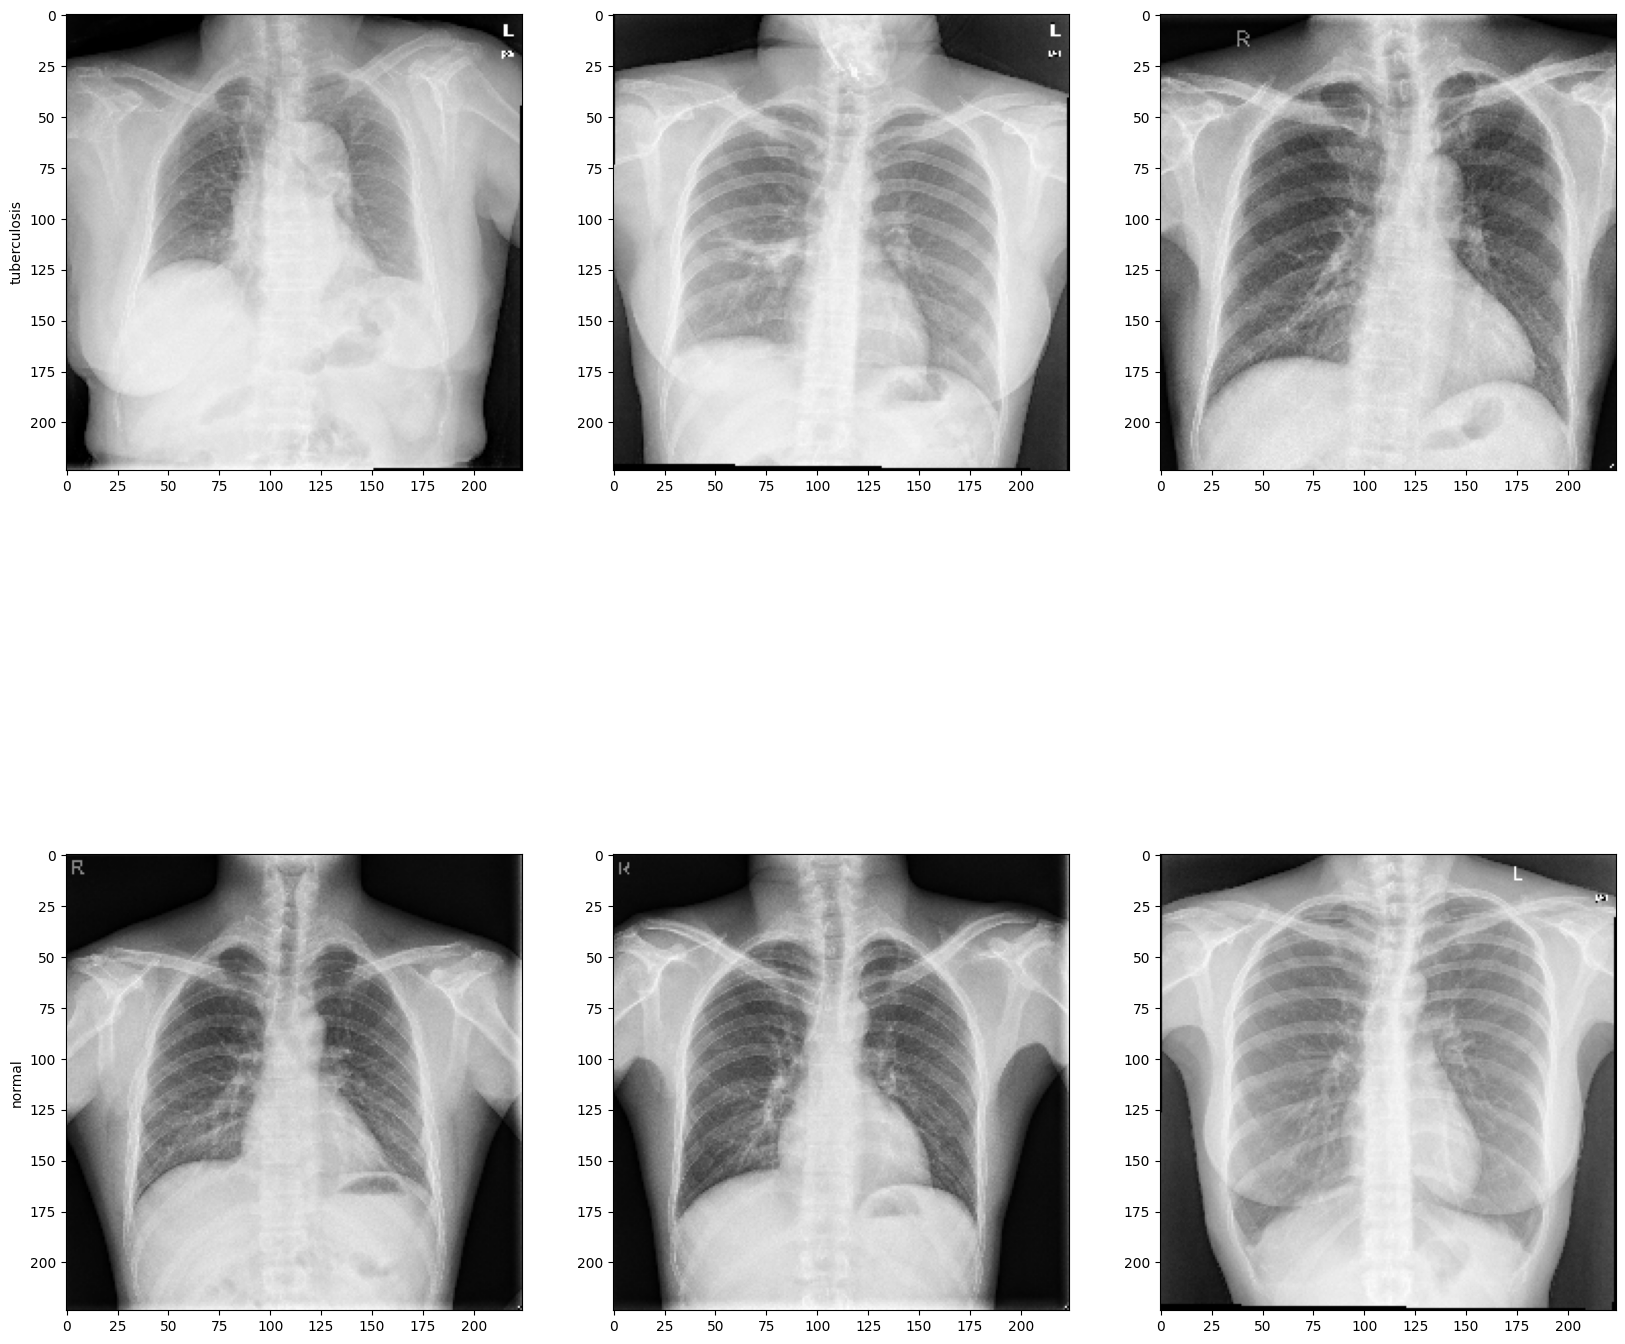

In [8]:
# Plot each image sample
fig, axes = plt.subplots(nrows=len(labels_list), ncols=n_samples, figsize=(20, 20))

for row_, label_ in enumerate(img_samples.keys()):
    for col_, name_ in enumerate(img_samples[label_]):
        axes[row_, col_].imshow(img_arrs[name_], cmap="gray")
        axes[row_, 0].set(ylabel=label_)